# Predicting Cancer Malignancy with a 2 layer neural network coded from scratch in Python.


**This notebook holds the Python code connected to this 3 part article:**

**<a href="https://towardsdatascience.com/the-keys-of-deep-learning-in-100-lines-of-code-907398c76504" target="_blank">Part 1</a> | <a href="https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2" target="_blank">Part 2</a> | <a href="https://medium.com/predicting-breast-cancer-tumors-with-your-own-neural-network-76271a05e941" target="_blank">Part 3</a>**<br>

**With this code and the associated articles, you are going to:**
- Create a neural network from scratch in Python. Train it using the gradient descent algorithm.
- Apply that basic network to The Wisconsin Cancer Data-set. Predict if a tumor is benign or malignant, based on 9 different features.
- Explore deeply how back-propagation and gradient descent work.
- Review the basics and explore advanced concepts. 





In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.stats import truncnorm
from sklearn.model_selection import train_test_split
import itertools

**The Dlnet 2 layer neural network class**

A 2 layer neural network class with gradient descent in less than 100 lines of code

In [2]:
def ft_accuracy_score(y, y_pred):
    y = y.values
    y_pred = y_pred
    summa = 0.0
    m = len(y)
    for i in range(m):
        if y[i] == y_pred[i]:
            summa += 1
    return summa / m

In [107]:
class dlnet:
    def __init__(self, hidden_neurons1, hidden_neurons2, out_neurons, learning_rate=0.1, weights=None):
        self.hidden_neurons1 = hidden_neurons1
        self.hidden_neurons2 = hidden_neurons2
        self.out_neurons = out_neurons
        
        self.weights = weights

        self.param = {}
        self.cach = {}
        self.loss = []
        self.loss_valid = []
        self.lr = learning_rate

    def init_bias(self, n_neurons):
        b = np.zeros(n_neurons)
        return b.reshape(-1, 1)

    def init_weights(self, n_inputs, n_neurons):
        random_state = np.random.randint(1000)
        stddev = 2 / np.sqrt(n_inputs + n_neurons)
        weights = truncnorm.rvs(-1, 1, size=(n_neurons, n_inputs), scale=stddev, random_state=random_state)
        return weights

    def sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))

    def dsigmoid(self, Z):      
        return Z * (1 - Z)
    
    def Relu(self, Z):
        return np.maximum(0,Z)

    def dRelu2(self, dZ, Z):    
        dZ[Z <= 0] = 0    
        return dZ

    def dRelu(self, x):
        x[x<=0] = 0
        x[x>0] = 1
        return x
    
    def softmax(self, Z):
        shiftx = Z - np.max(Z, axis=1).reshape(-1, 1)
        e = np.exp(shiftx)
        s = np.sum(e, axis=1).reshape(-1, 1)
        return e / s
    
    def dsoftmax(self, Z):
        p = self.cach['f3']
        dA = (Z * p).sum(axis=1).reshape(-1, 1)
        return p * (Z - dA)

    def init(self, m):
        self.param['W1'] = self.init_weights(m, self.hidden_neurons1)
        self.param['b1'] = self.init_bias(self.hidden_neurons1)
        self.param['W2'] = self.init_weights(self.hidden_neurons1, self.hidden_neurons2)
        self.param['b2'] = self.init_bias(self.hidden_neurons2)
        self.param['W3'] = self.init_weights(self.hidden_neurons2, self.out_neurons)
        self.param['b3'] = self.init_bias(self.out_neurons)
        pass

    def crossenthropy(self, y, y_pred):
        m = y.shape[1]
        return (-1.0 / m) * (y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

    def feedforward(self, X, weights, bias, activation=None):
        V = np.dot(weights, X) + bias
        if activation is not None:
            F = activation(V)
        return V, F
    
    def forward(self, X, y, activation=None):
        v1, f1 = self.feedforward(X, self.param['W1'], self.param['b1'], self.Relu)
        v2, f2 = self.feedforward(f1, self.param['W2'], self.param['b2'], self.Relu)
        v3, f3 = self.feedforward(f2, self.param['W3'], self.param['b3'], self.softmax)
        y_pred = f3

        self.cach['v1'] = v1
        self.cach['f1'] = f1
        self.cach['v2'] = v2
        self.cach['f2'] = f2
        self.cach['v3'] = v3
        self.cach['f3'] = f3

        loss = self.crossenthropy(y, y_pred)
        
        return y_pred, loss
    
    def backpropagation(self, X, y, y_pred):
        derror = -(np.divide(y, y_pred) - np.divide(1 - y, 1 - y_pred))

#         local_grad1 = derror * self.dsigmoid(derror)
        local_grad1 = self.dsoftmax(derror)
        grad_w3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, self.cach['f2'].T)
        grad_b3 = 1.0 / self.cach['f2'].shape[1] * np.dot(local_grad1, np.ones([local_grad1.shape[1], 1]))
        hidden_error1 = np.dot(self.param["W3"].T, local_grad1)

        local_grad2 = hidden_error1 * self.dRelu(self.cach['f2'])
        grad_w2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, self.cach['f1'].T)
        grad_b2 = 1. / self.cach['f1'].shape[1] * np.dot(local_grad2, np.ones([local_grad2.shape[1], 1]))
        hidden_error2 = np.dot(self.param['W2'].T, local_grad2)

        local_grad3 = hidden_error2 * self.dRelu(self.cach['f1'])
        grad_w1 = 1. / X.shape[1] * np.dot(local_grad3, X.T)
        grad_b1 = 1. / X.shape[1] * np.dot(local_grad3, np.ones([local_grad3.shape[1], 1]))

        self.param["W1"] -= self.lr * grad_w1
        self.param["b1"] -= self.lr * grad_b1
        self.param["W2"] -= self.lr * grad_w2
        self.param["b2"] -= self.lr * grad_b2
        self.param["W3"] -= self.lr * grad_w3
        self.param["b3"] -= self.lr * grad_b3
        
        pass

    def preprocess_X_y(self, X, y):
        X = X.T.values

        y = pd.DataFrame(y).copy()
        y[0] = y['target'].apply(lambda x: 0 if x == 1 else 1)
        y[1] = y['target'].apply(lambda x: 1 if x == 1 else 0)
        y.drop(['target'], axis=1, inplace=True)
        y = y.T.values

        return X, y

    def fit(self, X, y, n_epochs=2000, valid=None):
        m = X.shape[1]
        if valid != None:
            X_valid, y_valid = valid[0], valid[1]
            X_valid_for_accuracy = X_valid
            y_valid_for_accuracy = y_valid
        self.init(m)
        
        X_for_accuracy = X
        y_for_accuracy = y
        
        X, y = self.preprocess_X_y(X, y)

        i_list = []
        accuracy_list = []
        if valid != None:
            accuracy_valid_list = []
        
        for i in range(1, n_epochs + 1):
            if valid != None:
                y_proba_valid, loss_valid = self.predict_proba(X_valid, y_valid)
            
            y_proba, loss = self.forward(X, y)
            self.backpropagation(X, y, y_proba)
            
            ##-- loss
            if valid != None:
                loss_valid = np.sum(np.sum(loss_valid, axis=1))
            loss = np.sum(np.sum(loss, axis=1))
            
            ##-- predictions
            if valid != None:
                y_pred_valid = self.predict(X_valid_for_accuracy, y_valid_for_accuracy)
            y_pred = self.predict(X_for_accuracy, y_for_accuracy)
            
            ##-- accuracy
            if valid != None:
                accuracy_valid = ft_accuracy_score(y_valid_for_accuracy, y_pred_valid)
            accuracy = ft_accuracy_score(y_for_accuracy, y_pred)
            
            ##-- print
            if valid == None:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4}".format(i, n_epochs, loss, accuracy))
            else:
                print("epoch {0:>5}/{1} - loss: {2:<6.4} - accuracy: {3:<6.4} - val_loss: {4:<6.4} - val_accuracy: {5:.4}".format(i, n_epochs, loss, 
                                                                                   accuracy, loss_valid, 
                                                                                   accuracy_valid))
            
            ##-- append
            if valid != None:
                self.loss_valid.append(loss_valid)
                accuracy_valid_list.append(accuracy_valid)
            self.loss.append(loss)
            i_list.append(i)
            accuracy_list.append(accuracy)
        
        plt.figure(figsize=(16, 6))
        plt.plot(i_list, self.loss, label='loss')
        if valid != None:
            plt.plot(i_list, self.loss_valid, label='val_loss')     
            plt.plot(i_list, accuracy_valid_list, label='val_accuracy') 
        plt.plot(i_list, accuracy_list, label='accuracy')
        
        plt.title("Learning rate =" + str(self.lr))
        plt.legend()
        plt.grid(True)
        plt.show()
        
        ##--save weights
        self.weights = []
        self.weights.append([self.param["W1"],
                                 self.param["b1"],
                                 self.param["W2"],
                                 self.param["b2"],
                                 self.param["W3"],
                                 self.param["b3"]])

        return


    def predict_proba(self, X, y):
        X, y = self.preprocess_X_y(X, y)
        y_pred, loss = self.forward(X, y)
        return y_pred, loss

    def predict(self, X, y):
        y_pred, _ = self.predict_proba(X, y)
        predict = np.array([x for x in y_pred.argmax(axis=0)])
        return predict

# Prepare the data

In [149]:
df = pd.read_csv('data.csv', names = ['1','target','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','32'] )
df.drop(['1'], axis=1, inplace=True)
df['target'] = df['target'].apply(lambda x: 1 if x=='M' else 0)
not_normalized_cols = ['3', '4', '5', '6', '15', '16', '23', '24', '25', '26']
scaler = MinMaxScaler()
df[not_normalized_cols] = scaler.fit_transform(df[not_normalized_cols])
target = df['target'].copy()

# df = df.drop(['23','26','25','13','15','16','3','5','6'], axis=1)
df.drop(['target'], axis=1, inplace=True)

In [150]:
X = df
y = target

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [152]:
X_valid, y_valid = X_train[:50], y_train[:50]
X_train, y_train = X_train[50:], y_train[50:]

epoch     1/2000 - loss: 6.014  - accuracy: 0.4296 - val_loss: 3.944  - val_accuracy: 0.38
epoch     2/2000 - loss: 6.013  - accuracy: 0.4543 - val_loss: 3.942  - val_accuracy: 0.4
epoch     3/2000 - loss: 6.012  - accuracy: 0.4642 - val_loss: 3.941  - val_accuracy: 0.4
epoch     4/2000 - loss: 6.011  - accuracy: 0.479  - val_loss: 3.94   - val_accuracy: 0.4
epoch     5/2000 - loss: 6.01   - accuracy: 0.4815 - val_loss: 3.939  - val_accuracy: 0.42
epoch     6/2000 - loss: 6.009  - accuracy: 0.4988 - val_loss: 3.937  - val_accuracy: 0.46
epoch     7/2000 - loss: 6.008  - accuracy: 0.5136 - val_loss: 3.936  - val_accuracy: 0.46
epoch     8/2000 - loss: 6.007  - accuracy: 0.5309 - val_loss: 3.935  - val_accuracy: 0.46
epoch     9/2000 - loss: 6.006  - accuracy: 0.5506 - val_loss: 3.934  - val_accuracy: 0.48
epoch    10/2000 - loss: 6.005  - accuracy: 0.5753 - val_loss: 3.933  - val_accuracy: 0.56
epoch    11/2000 - loss: 6.004  - accuracy: 0.5877 - val_loss: 3.932  - val_accuracy: 0.56
ep

epoch   102/2000 - loss: 5.727  - accuracy: 0.9481 - val_loss: 3.619  - val_accuracy: 0.96
epoch   103/2000 - loss: 5.724  - accuracy: 0.9481 - val_loss: 3.616  - val_accuracy: 0.96
epoch   104/2000 - loss: 5.722  - accuracy: 0.9481 - val_loss: 3.613  - val_accuracy: 0.96
epoch   105/2000 - loss: 5.719  - accuracy: 0.9481 - val_loss: 3.61   - val_accuracy: 0.96
epoch   106/2000 - loss: 5.717  - accuracy: 0.9481 - val_loss: 3.607  - val_accuracy: 0.96
epoch   107/2000 - loss: 5.715  - accuracy: 0.9506 - val_loss: 3.605  - val_accuracy: 0.96
epoch   108/2000 - loss: 5.713  - accuracy: 0.9506 - val_loss: 3.602  - val_accuracy: 0.96
epoch   109/2000 - loss: 5.711  - accuracy: 0.9531 - val_loss: 3.6    - val_accuracy: 0.96
epoch   110/2000 - loss: 5.709  - accuracy: 0.9531 - val_loss: 3.598  - val_accuracy: 0.96
epoch   111/2000 - loss: 5.707  - accuracy: 0.9556 - val_loss: 3.596  - val_accuracy: 0.96
epoch   112/2000 - loss: 5.705  - accuracy: 0.9556 - val_loss: 3.594  - val_accuracy: 0.96

epoch   197/2000 - loss: 5.649  - accuracy: 0.9605 - val_loss: 3.55   - val_accuracy: 0.96
epoch   198/2000 - loss: 5.649  - accuracy: 0.9605 - val_loss: 3.55   - val_accuracy: 0.96
epoch   199/2000 - loss: 5.649  - accuracy: 0.9605 - val_loss: 3.55   - val_accuracy: 0.96
epoch   200/2000 - loss: 5.648  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   201/2000 - loss: 5.648  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   202/2000 - loss: 5.648  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   203/2000 - loss: 5.648  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   204/2000 - loss: 5.647  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   205/2000 - loss: 5.647  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   206/2000 - loss: 5.647  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96
epoch   207/2000 - loss: 5.647  - accuracy: 0.9605 - val_loss: 3.549  - val_accuracy: 0.96

epoch   301/2000 - loss: 5.623  - accuracy: 0.9605 - val_loss: 3.531  - val_accuracy: 0.96
epoch   302/2000 - loss: 5.622  - accuracy: 0.9605 - val_loss: 3.531  - val_accuracy: 0.96
epoch   303/2000 - loss: 5.622  - accuracy: 0.9605 - val_loss: 3.531  - val_accuracy: 0.96
epoch   304/2000 - loss: 5.622  - accuracy: 0.9605 - val_loss: 3.53   - val_accuracy: 0.96
epoch   305/2000 - loss: 5.621  - accuracy: 0.9605 - val_loss: 3.53   - val_accuracy: 0.96
epoch   306/2000 - loss: 5.621  - accuracy: 0.9605 - val_loss: 3.53   - val_accuracy: 0.96
epoch   307/2000 - loss: 5.62   - accuracy: 0.9605 - val_loss: 3.529  - val_accuracy: 0.96
epoch   308/2000 - loss: 5.62   - accuracy: 0.9605 - val_loss: 3.529  - val_accuracy: 0.96
epoch   309/2000 - loss: 5.619  - accuracy: 0.9605 - val_loss: 3.528  - val_accuracy: 0.96
epoch   310/2000 - loss: 5.619  - accuracy: 0.9605 - val_loss: 3.528  - val_accuracy: 0.96
epoch   311/2000 - loss: 5.618  - accuracy: 0.9605 - val_loss: 3.527  - val_accuracy: 0.98

epoch   403/2000 - loss: 5.578  - accuracy: 0.9654 - val_loss: 3.484  - val_accuracy: 0.98
epoch   404/2000 - loss: 5.578  - accuracy: 0.9654 - val_loss: 3.484  - val_accuracy: 0.98
epoch   405/2000 - loss: 5.577  - accuracy: 0.9654 - val_loss: 3.483  - val_accuracy: 0.98
epoch   406/2000 - loss: 5.577  - accuracy: 0.9654 - val_loss: 3.483  - val_accuracy: 0.98
epoch   407/2000 - loss: 5.577  - accuracy: 0.9654 - val_loss: 3.483  - val_accuracy: 0.98
epoch   408/2000 - loss: 5.576  - accuracy: 0.9654 - val_loss: 3.482  - val_accuracy: 0.98
epoch   409/2000 - loss: 5.576  - accuracy: 0.9654 - val_loss: 3.482  - val_accuracy: 0.98
epoch   410/2000 - loss: 5.576  - accuracy: 0.9654 - val_loss: 3.481  - val_accuracy: 0.98
epoch   411/2000 - loss: 5.575  - accuracy: 0.9654 - val_loss: 3.481  - val_accuracy: 0.98
epoch   412/2000 - loss: 5.575  - accuracy: 0.9654 - val_loss: 3.481  - val_accuracy: 0.98
epoch   413/2000 - loss: 5.575  - accuracy: 0.9654 - val_loss: 3.48   - val_accuracy: 0.98

epoch   509/2000 - loss: 5.545  - accuracy: 0.963  - val_loss: 3.446  - val_accuracy: 0.98
epoch   510/2000 - loss: 5.545  - accuracy: 0.963  - val_loss: 3.446  - val_accuracy: 0.98
epoch   511/2000 - loss: 5.544  - accuracy: 0.9605 - val_loss: 3.445  - val_accuracy: 0.98
epoch   512/2000 - loss: 5.544  - accuracy: 0.9605 - val_loss: 3.445  - val_accuracy: 0.98
epoch   513/2000 - loss: 5.544  - accuracy: 0.9605 - val_loss: 3.445  - val_accuracy: 0.98
epoch   514/2000 - loss: 5.543  - accuracy: 0.9605 - val_loss: 3.444  - val_accuracy: 0.98
epoch   515/2000 - loss: 5.543  - accuracy: 0.9605 - val_loss: 3.444  - val_accuracy: 0.98
epoch   516/2000 - loss: 5.543  - accuracy: 0.9605 - val_loss: 3.444  - val_accuracy: 0.98
epoch   517/2000 - loss: 5.543  - accuracy: 0.9605 - val_loss: 3.443  - val_accuracy: 0.98
epoch   518/2000 - loss: 5.542  - accuracy: 0.9605 - val_loss: 3.443  - val_accuracy: 0.98
epoch   519/2000 - loss: 5.542  - accuracy: 0.9605 - val_loss: 3.443  - val_accuracy: 0.98

epoch   618/2000 - loss: 5.512  - accuracy: 0.9654 - val_loss: 3.41   - val_accuracy: 0.98
epoch   619/2000 - loss: 5.511  - accuracy: 0.9654 - val_loss: 3.41   - val_accuracy: 0.98
epoch   620/2000 - loss: 5.511  - accuracy: 0.9654 - val_loss: 3.41   - val_accuracy: 0.98
epoch   621/2000 - loss: 5.511  - accuracy: 0.9654 - val_loss: 3.41   - val_accuracy: 0.98
epoch   622/2000 - loss: 5.511  - accuracy: 0.9654 - val_loss: 3.409  - val_accuracy: 0.98
epoch   623/2000 - loss: 5.51   - accuracy: 0.9654 - val_loss: 3.409  - val_accuracy: 0.98
epoch   624/2000 - loss: 5.51   - accuracy: 0.9654 - val_loss: 3.409  - val_accuracy: 0.98
epoch   625/2000 - loss: 5.51   - accuracy: 0.9654 - val_loss: 3.409  - val_accuracy: 0.98
epoch   626/2000 - loss: 5.509  - accuracy: 0.9654 - val_loss: 3.408  - val_accuracy: 0.98
epoch   627/2000 - loss: 5.509  - accuracy: 0.9654 - val_loss: 3.408  - val_accuracy: 0.98
epoch   628/2000 - loss: 5.509  - accuracy: 0.9654 - val_loss: 3.408  - val_accuracy: 0.98

epoch   724/2000 - loss: 5.488  - accuracy: 0.9704 - val_loss: 3.389  - val_accuracy: 0.98
epoch   725/2000 - loss: 5.488  - accuracy: 0.9704 - val_loss: 3.389  - val_accuracy: 0.98
epoch   726/2000 - loss: 5.488  - accuracy: 0.9704 - val_loss: 3.389  - val_accuracy: 0.98
epoch   727/2000 - loss: 5.487  - accuracy: 0.9704 - val_loss: 3.389  - val_accuracy: 0.98
epoch   728/2000 - loss: 5.487  - accuracy: 0.9704 - val_loss: 3.389  - val_accuracy: 0.98
epoch   729/2000 - loss: 5.487  - accuracy: 0.9728 - val_loss: 3.389  - val_accuracy: 0.98
epoch   730/2000 - loss: 5.487  - accuracy: 0.9728 - val_loss: 3.389  - val_accuracy: 0.98
epoch   731/2000 - loss: 5.487  - accuracy: 0.9728 - val_loss: 3.388  - val_accuracy: 0.98
epoch   732/2000 - loss: 5.487  - accuracy: 0.9728 - val_loss: 3.388  - val_accuracy: 0.98
epoch   733/2000 - loss: 5.486  - accuracy: 0.9728 - val_loss: 3.388  - val_accuracy: 0.98
epoch   734/2000 - loss: 5.486  - accuracy: 0.9728 - val_loss: 3.388  - val_accuracy: 0.98

epoch   832/2000 - loss: 5.473  - accuracy: 0.9753 - val_loss: 3.378  - val_accuracy: 0.98
epoch   833/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   834/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   835/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   836/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   837/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   838/2000 - loss: 5.473  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   839/2000 - loss: 5.472  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   840/2000 - loss: 5.472  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   841/2000 - loss: 5.472  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98
epoch   842/2000 - loss: 5.472  - accuracy: 0.9728 - val_loss: 3.378  - val_accuracy: 0.98

epoch   939/2000 - loss: 5.463  - accuracy: 0.9802 - val_loss: 3.372  - val_accuracy: 0.98
epoch   940/2000 - loss: 5.463  - accuracy: 0.9802 - val_loss: 3.372  - val_accuracy: 0.98
epoch   941/2000 - loss: 5.463  - accuracy: 0.9778 - val_loss: 3.372  - val_accuracy: 0.98
epoch   942/2000 - loss: 5.463  - accuracy: 0.9802 - val_loss: 3.372  - val_accuracy: 0.98
epoch   943/2000 - loss: 5.463  - accuracy: 0.9802 - val_loss: 3.371  - val_accuracy: 0.98
epoch   944/2000 - loss: 5.462  - accuracy: 0.9778 - val_loss: 3.371  - val_accuracy: 0.98
epoch   945/2000 - loss: 5.462  - accuracy: 0.9802 - val_loss: 3.371  - val_accuracy: 0.98
epoch   946/2000 - loss: 5.462  - accuracy: 0.9802 - val_loss: 3.371  - val_accuracy: 0.98
epoch   947/2000 - loss: 5.462  - accuracy: 0.9778 - val_loss: 3.371  - val_accuracy: 0.98
epoch   948/2000 - loss: 5.462  - accuracy: 0.9802 - val_loss: 3.371  - val_accuracy: 0.98
epoch   949/2000 - loss: 5.462  - accuracy: 0.9802 - val_loss: 3.371  - val_accuracy: 0.98

epoch  1042/2000 - loss: 5.455  - accuracy: 0.9778 - val_loss: 3.367  - val_accuracy: 0.98
epoch  1043/2000 - loss: 5.455  - accuracy: 0.9778 - val_loss: 3.367  - val_accuracy: 0.98
epoch  1044/2000 - loss: 5.455  - accuracy: 0.9778 - val_loss: 3.367  - val_accuracy: 0.98
epoch  1045/2000 - loss: 5.455  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1046/2000 - loss: 5.455  - accuracy: 0.9778 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1047/2000 - loss: 5.455  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1048/2000 - loss: 5.455  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1049/2000 - loss: 5.455  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1050/2000 - loss: 5.454  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1051/2000 - loss: 5.454  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98
epoch  1052/2000 - loss: 5.454  - accuracy: 0.9802 - val_loss: 3.366  - val_accuracy: 0.98

epoch  1146/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.362  - val_accuracy: 0.98
epoch  1147/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.362  - val_accuracy: 0.98
epoch  1148/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.362  - val_accuracy: 0.98
epoch  1149/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.362  - val_accuracy: 0.98
epoch  1150/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1151/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1152/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1153/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1154/2000 - loss: 5.448  - accuracy: 0.9778 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1155/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98
epoch  1156/2000 - loss: 5.448  - accuracy: 0.9802 - val_loss: 3.361  - val_accuracy: 0.98

epoch  1244/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1245/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.359  - val_accuracy: 0.98
epoch  1246/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1247/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1248/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1249/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1250/2000 - loss: 5.443  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1251/2000 - loss: 5.442  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1252/2000 - loss: 5.442  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1253/2000 - loss: 5.442  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98
epoch  1254/2000 - loss: 5.442  - accuracy: 0.9802 - val_loss: 3.358  - val_accuracy: 0.98

epoch  1338/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98
epoch  1339/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.355  - val_accuracy: 0.98
epoch  1340/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98
epoch  1341/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.355  - val_accuracy: 0.98
epoch  1342/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98
epoch  1343/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.355  - val_accuracy: 0.98
epoch  1344/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98
epoch  1345/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.355  - val_accuracy: 0.98
epoch  1346/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98
epoch  1347/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.355  - val_accuracy: 0.98
epoch  1348/2000 - loss: 5.438  - accuracy: 0.9827 - val_loss: 3.354  - val_accuracy: 0.98

epoch  1444/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1445/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1446/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.352  - val_accuracy: 0.98
epoch  1447/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1448/2000 - loss: 5.434  - accuracy: 0.9877 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1449/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1450/2000 - loss: 5.434  - accuracy: 0.9877 - val_loss: 3.352  - val_accuracy: 0.98
epoch  1451/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1452/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1453/2000 - loss: 5.434  - accuracy: 0.9852 - val_loss: 3.351  - val_accuracy: 0.98
epoch  1454/2000 - loss: 5.434  - accuracy: 0.9877 - val_loss: 3.351  - val_accuracy: 0.98

epoch  1553/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98
epoch  1554/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.348  - val_accuracy: 0.98
epoch  1555/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98
epoch  1556/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.348  - val_accuracy: 0.98
epoch  1557/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98
epoch  1558/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.348  - val_accuracy: 0.98
epoch  1559/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98
epoch  1560/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.348  - val_accuracy: 0.98
epoch  1561/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98
epoch  1562/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.348  - val_accuracy: 0.98
epoch  1563/2000 - loss: 5.43   - accuracy: 0.9901 - val_loss: 3.349  - val_accuracy: 0.98

epoch  1657/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98
epoch  1658/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.347  - val_accuracy: 0.98
epoch  1659/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98
epoch  1660/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.347  - val_accuracy: 0.98
epoch  1661/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98
epoch  1662/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.347  - val_accuracy: 0.98
epoch  1663/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98
epoch  1664/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.347  - val_accuracy: 0.98
epoch  1665/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98
epoch  1666/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.347  - val_accuracy: 0.98
epoch  1667/2000 - loss: 5.426  - accuracy: 0.9901 - val_loss: 3.346  - val_accuracy: 0.98

epoch  1767/2000 - loss: 5.423  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1768/2000 - loss: 5.423  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1769/2000 - loss: 5.423  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1770/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1771/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1772/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1773/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1774/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1775/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1776/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98
epoch  1777/2000 - loss: 5.422  - accuracy: 0.9901 - val_loss: 3.345  - val_accuracy: 0.98

epoch  1876/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1877/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1878/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1879/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1880/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1881/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1882/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1883/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1884/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1885/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1886/2000 - loss: 5.419  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98

epoch  1984/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.342  - val_accuracy: 0.98
epoch  1985/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1986/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.342  - val_accuracy: 0.98
epoch  1987/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1988/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.341  - val_accuracy: 0.98
epoch  1989/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1990/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.341  - val_accuracy: 0.98
epoch  1991/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.344  - val_accuracy: 0.98
epoch  1992/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.341  - val_accuracy: 0.98
epoch  1993/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.343  - val_accuracy: 0.98
epoch  1994/2000 - loss: 5.416  - accuracy: 0.9901 - val_loss: 3.341  - val_accuracy: 0.98

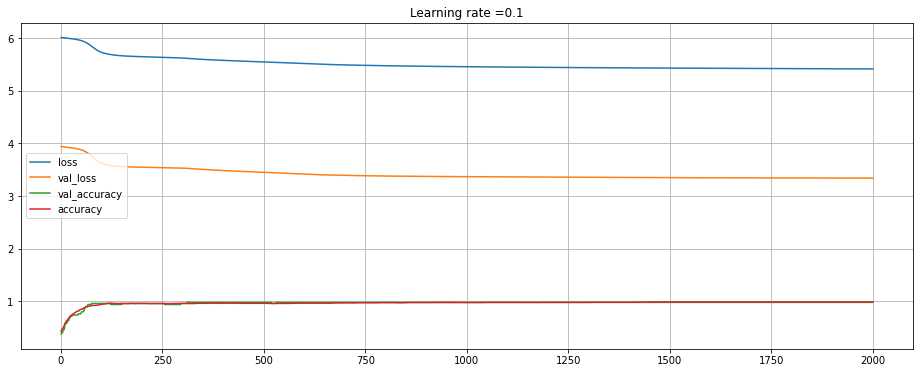

In [153]:
# %%time
nn = dlnet(10, 5, 2, 0.1)
nn.fit(X_train, y_train, n_epochs=2000, valid=(X_valid, y_valid))

In [154]:
y_proba, _ = nn.predict_proba(X_test, y_test)
pd.DataFrame(y_proba)

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,0.000152,0.013775,0.016877,0.000533,0.000335,0.000844,0.000131,0.014539,0.000550,0.013395,...,0.012917,0.000701,0.015856,0.000175,0.000535,0.016499,0.000338,0.000323,0.000168,0.000146
1,0.021492,0.000291,0.000313,0.022081,0.021505,0.023574,0.026638,0.000365,0.019081,0.000296,...,0.000286,0.021769,0.000258,0.017660,0.025461,0.000408,0.022983,0.024283,0.021072,0.022820


In [155]:
y_pred = nn.predict(X_test, y_test)
pd.DataFrame(y_pred)

,0
0,1
1,0
2,0
3,1
4,1
...,...
109,0
110,1
111,1
112,1


In [156]:
print("{}: {}".format("Accuracy", ft_accuracy_score(y_test, y_pred)))

Accuracy: 0.956140350877193


In [157]:
pd.DataFrame(y_test).T

,202,96,151,351,492,172,564,494,566,285,...,222,444,443,368,199,445,121,516,535,23
target,1,0,0,1,1,1,1,0,1,0,...,0,1,0,1,1,0,1,1,1,1


In [158]:
pd.DataFrame(y_pred).T

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,1,0,0,1,1,1,1,0,1,0,...,0,1,0,1,1,0,1,1,1,1


In [159]:
confusion_matrix(y_test, y_pred)

array([[65,  1],
       [ 4, 44]], dtype=int64)

In [160]:
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(a))) # length of classes
    class_labels = ['0','1']
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();

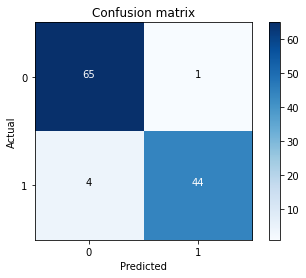

In [161]:
plotCf(y_test, y_pred, 'Confusion matrix')